# Mid-Ratio Histogram Test

In this section, we take a closer look at the authors' mid ratio test. They look at the ordered triplet (a,b,c); a < b < c and plot the ratio of (b-a)/(c-a) and show an anomaly for the particular RTS. We will conduct the following tests:

To Do - Various plots that we will plot in this section

- First, try to reproduce what the authors did. Figure (1)

- Second, we pool in all the data and try to test for anomalous patterns by singling out each individual from the pool and plotting it compared to the rest of them put together excluding/including the individual?

- Third, we do a permutation test, by making random draws of N_RTS samples from the pooled data (all users) and calibrating the empirical distribution of mid ratio in such a random draw, and then testing for the surprising behavior of the "RTS"'s test statistic.

In [270]:
# import numpy and matlab plot library

import numpy as np

# VERY IMPORTANT line
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

# import panda
import pandas as pd

# import chisquare statistics
from scipy.stats import chisquare,kstest

In [547]:
# This function removes row containing NA values from the dataframe and converts it to a matrix, and returns only last 
# 3 columns. For the rest data, there is an extra column indexing the person, which we ignore for our computations of mid-ratios.
def process(df):    
    data = df.dropna(axis = 0)
    data = data.as_matrix()
    return data[:,-3:]

# This function simply plots a histogram of the data (named ratio) with a given title and displays it inline.
def plot_np_hist(ratio, s='Title', show=False):
    plt.hist(ratio, bins=10, normed = False)
    plt.title(s)
    if show:
        plt.show()
    
# This function takes an N by 3 matrix, sorts the matrix row wise, and then computes the ratio of (mid-min)/(max-min)
# for each row (excludes the rows with all equal entries.)
def calculate_ratio(M):
    M = M[:, -3:]
    M.sort(axis=1)
    if (M.shape[1]!=3):
        print 'Size is flawed '
        print M.shape
        
    mid_min = M[:, 1] - M[:, 0]
    max_min = M[:, 2] - M[:, 0]
    ratio = ([mid_min[t]/max_min[t] for t in range(max_min.shape[0]) if max_min[t] !=0 ])
    return ratio

# The next two functions are for obtaining histograms that look similar to the ones given in the paper. In these versions
# since we have to include the right hand edge, I do it manually - both the computation and the plotting of the bars.
def calculate_my_histogram(ratio):
    v = np.zeros(10)
    N = len(ratio)
    v[0] = np.sum([( x <= 0.1) for x in ratio])
    for i in range(2, 11):
        thr = float(i) /10.
        v[i-1] = np.sum([( x <= thr and x > thr-0.1) for x in ratio])
    v /= np.sum(v)
    return v
def plot_my_histogram(v, s='Title', show=False):
    x = np.linspace(0,1,10,endpoint=False)
    plt.bar(x, v, width=0.1)
    plt.title(s)
    if show:
        plt.show()

# This function extracts first three columns of values in the grouped_by data set
def group_by_name(df):
    a = df.values
    a.sort(axis=1)
    return a[:,0:3]

# This function returns a list of last digits for an np array/ndarray input


In [548]:
# Load and process the datasets, remove NANs and remove the labels (labels will be handy later on)

rts_colony_df = pd.read_excel("data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx", na_values = [' '], skiprows=[0,1], parse_cols = ("D:F"), header = 0)   
rts_colony = process(rts_colony_df)

rest_colony_df = pd.read_excel("data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx", na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:F"))
rest_colony = process(rest_colony_df)

In [552]:
# Merge the data to create the pool and visualize the shape of the datasets
pool_colony = np.vstack([rts_colony, rest_colony])
print pool_colony
print rts_colony.shape
print rest_colony.shape
print pool_colony.shape

[[78.0 91.0 93.0]
 [88.0 90.0 90.0]
 [66.0 69.0 80.0]
 ..., 
 [32 32.0 37.0]
 [34.0 35.0 39]
 [29.0 37 38.0]]
(1361, 3)
(597, 3)
(1958, 3)


In [553]:
# Grouped Data from the rest dataset to be used later on for individual statistics
rest_colony_no_nan = rest_colony_df.dropna(axis=0)
rest_colony_grouped = rest_colony_no_nan.groupby("Inv").apply(group_by_name)
names_colony = rest_colony_grouped.index

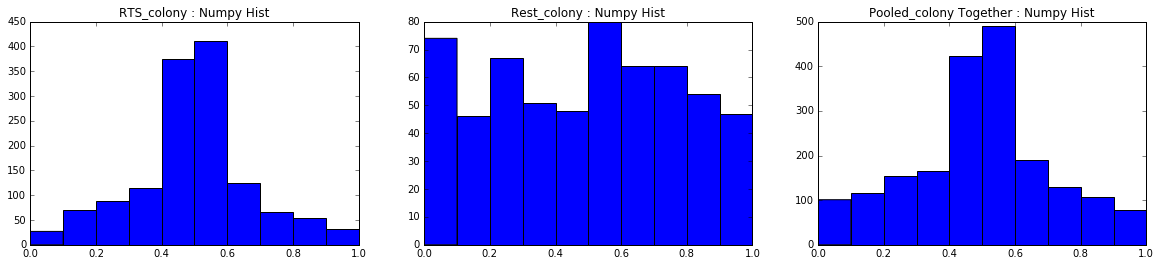

In [554]:
# Plot simple numpy histograms of mid-ratios for RTS, Rest and Pooled COLONY Data

plt.figure(figsize=[20,4])
plt.subplot(1,3,1)
ratio_rts_colony = calculate_ratio(rts_colony)
plot_np_hist(ratio_rts_colony, 'RTS_colony : Numpy Hist')
plt.subplot(1,3,2)
ratio_rest_colony = calculate_ratio(rest_colony)
plot_np_hist(ratio_rest_colony, 'Rest_colony : Numpy Hist')
plt.subplot(1,3,3)
ratio_pool_colony = calculate_ratio(pool_colony)
plot_np_hist(ratio_pool_colony, 'Pooled_colony Together : Numpy Hist')
plt.show()

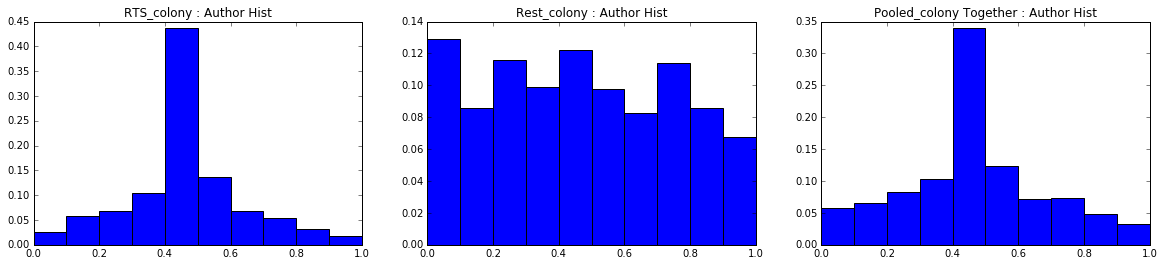

In [555]:
## Here we try to adapt the convetion used by the authors in reporting the histogram. They include the data 
## at the right end of the interval, we correct for it here and see that these new plots look very similar to their plots.

plt.figure(figsize=[20,4])
plt.subplot(1,3,1)
hist_ratio_colony = calculate_my_histogram(ratio_rts_colony)
plot_my_histogram(hist_ratio_colony, 'RTS_colony : Author Hist')
plt.subplot(1,3,2)
hist_rest_colony =  calculate_my_histogram(ratio_rest_colony)
plot_my_histogram(hist_rest_colony, 'Rest_colony : Author Hist')
plt.subplot(1,3,3)
hist_pool_colony = calculate_my_histogram(ratio_pool_colony)
plot_my_histogram(hist_pool_colony, 'Pooled_colony Together : Author Hist')
plt.show()

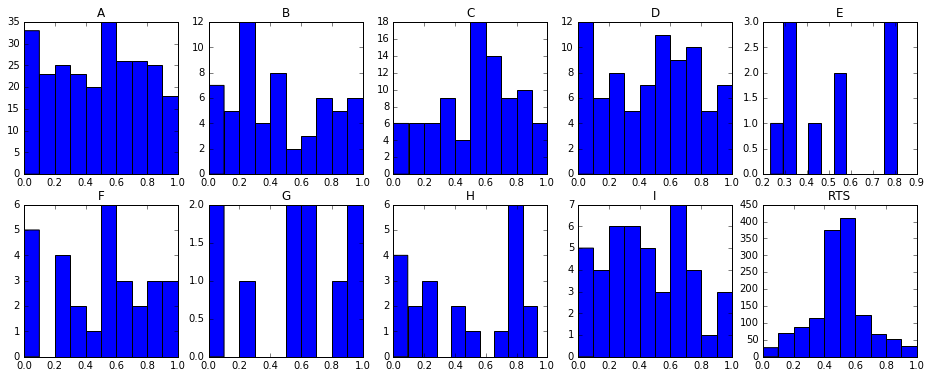

In [422]:
# Now, we decompose the rest group by the unnamed labmates, there are 9 other labmates. We plot the mid-ratio histogram
# using numpy, and also plot the histogram of RTS at the end. Thus there are 10 plots to look at.
ratios_colony = {}
plt.figure(figsize = [16,6])
for group in range(rest_colony_grouped.shape[0]):
    ratios_colony[group]= calculate_ratio(rest_colony_grouped[group])
    plt.subplot(2,5, group+1)
    plot_np_hist(ratios_colony[group], names_colony[group])
plt.subplot(2,5,10)
plot_np_hist(calculate_ratio(rts_colony), 'RTS_colony', True)
plt.show()

In [529]:
rts_coulter_df = pd.read_excel("data/Bishayee Coulter Counts.10.20.97-7.16.01.xlsx", na_values = [' '], skiprows=[1,2], parse_cols = ("C:E"), header = 0)   
rts_coulter = rts_coulter_df.as_matrix()

rest_coulter_df = pd.read_excel("data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx", na_values = [' '], header = 0, skiprows = [0], 
                         parse_cols = ("C:E,G"))
rest_coulter = rest_coulter_df.as_matrix()[:,0:3]
# We don't drop NANs for last digit
# rest_coulter_with_label = rest_coulter_df.as_matrix() # Last column is the label of investigator
# rest_coulter_no_nan = (rest_coulter_df.dropna(axis=0)).as_matrix()
# In case we need later

In [530]:
pool_coulter = np.vstack([rts_coulter, rest_coulter])
print rts_coulter.shape
print rest_coulter.shape
print pool_coulter.shape

(1728, 3)
(1007, 3)
(2735, 3)


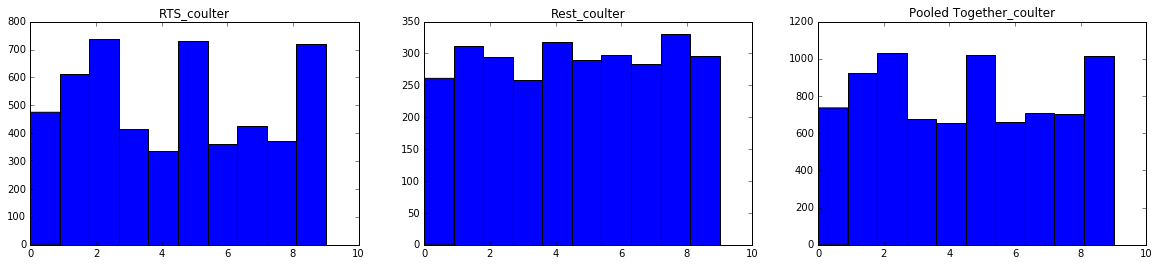

In [556]:
# In this section we plot the distribution of last digit for RTS, Rest and All of them pooled together
# THIS IS NOT USEFUL HERE BECAUSE WE WANT TO DO THAT FOR COULTER DATASET AND COLONY DATASET
def compute_last_digit(n_arr):
    n_arr = n_arr.flatten()
    return [int (n%10) for n in n_arr if not(np.isnan(n))]

plt.figure(figsize=[20,4])
plt.subplot(1,3,1)
last_digit_rts_coulter = compute_last_digit(rts_coulter)
plot_np_hist(last_digit_rts_coulter, 'RTS_coulter')
plt.subplot(1,3,2)
last_digit_rest_coulter = compute_last_digit(rest_coulter)
plot_np_hist(last_digit_rest_coulter, 'Rest_coulter')
plt.subplot(1,3,3)
last_digit_pool_coulter = compute_last_digit(pool_coulter)
plot_np_hist(last_digit_pool_coulter, 'Pooled Together_coulter')
plt.show()

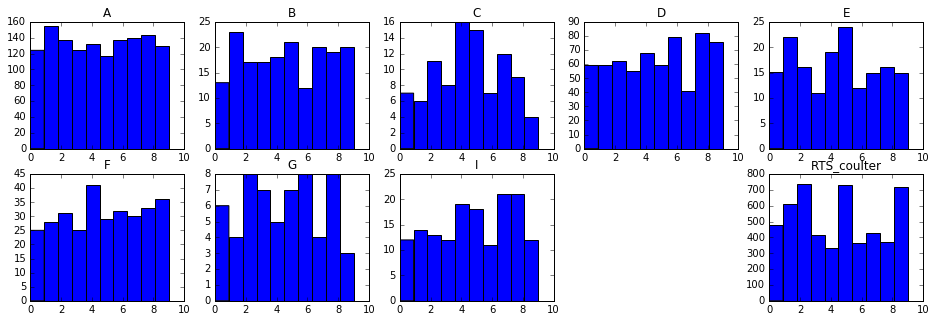

In [575]:
# Now, we decompose the rest group by the unnamed labmates, there are 9 other labmates. We plot last-digit histogram

rest_coulter_grouped = rest_coulter_df.groupby("Investigator").apply(group_by_name)
names_coulter = rest_coulter_grouped.index
last_digit_coulter = {}
chi_digit_coulter  = {}
plt.figure(figsize = [16,5])
for group in range(rest_coulter_grouped.shape[0]):
    last_digit_coulter[group] = compute_last_digit(rest_coulter_grouped[group])
    plt.subplot(2,5, group+1)
    chi_digit_coulter[names_coulter[group]] = chisquare(last_digit_coulter[group])[1]
    plot_np_hist(last_digit_coulter[group], names_coulter[group])
plt.subplot(2,5,10)
last_digit_rts_coulter = compute_last_digit(rts_coulter)
chi_digit_rts = chisquare(last_digit_rts_coulter)[1]
plot_np_hist(last_digit_rts_coulter, 'RTS_coulter', True)
plt.show()

In [589]:
# print chi_digit_rts
# print chi_digit_coulter.values()
# print last_digit_pool_coulter
import scipy.stats as ss
from scipy.stats import kstest
# print chisquare(last_digit_pool_coulter)[1]
# print chisquare(last_digit_rest_coulter)[1]
# print chisquare(last_digit_rts_coulter)[1]

In [628]:
kstest(np.random.randint(0, 10, 1000), lambda x: (x+1)/10.)

KstestResult(statistic=0.10799999999999998, pvalue=1.3009726629320539e-10)

(array([   14.,    98.,   486.,  1424.,  2479.,  2788.,  1785.,   727.,
          175.,    24.]),
 array([-0.03909211, -0.03153331, -0.0239745 , -0.0164157 , -0.00885689,
        -0.00129809,  0.00626071,  0.01381952,  0.02137832,  0.02893713,
         0.03649593]),
 <a list of 10 Patch objects>)

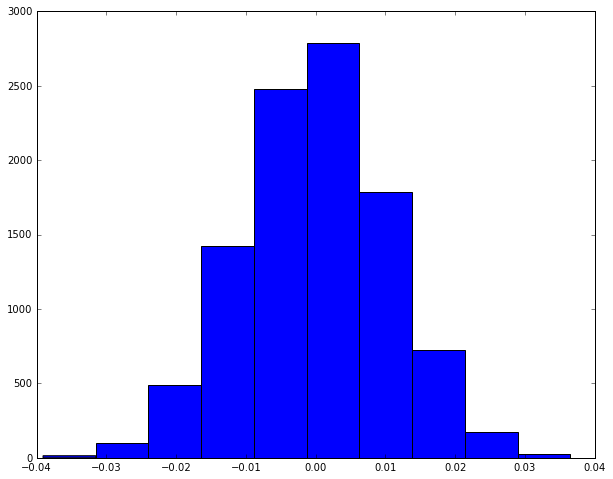

In [646]:
# Permutation Test
num_rts = rts_colony.shape[0]
num_tot = pool_colony.shape[0]

idxs =  range(num_tot)

num_test = 10000

stat = np.zeros(num_test)
for j in range(num_test):
    idx_rts = np.random.choice(idxs, num_rts, replace=True)
    idx_rest = np.setdiff1d(idxs, idx_rts)
    rts_sample = pool_colony[idx_rts,:]
    rest_sample = pool_colony[idx_rest,:]
    stat[j] = np.mean(calculate_ratio(rts_sample))-np.mean(calculate_ratio(rest_sample))


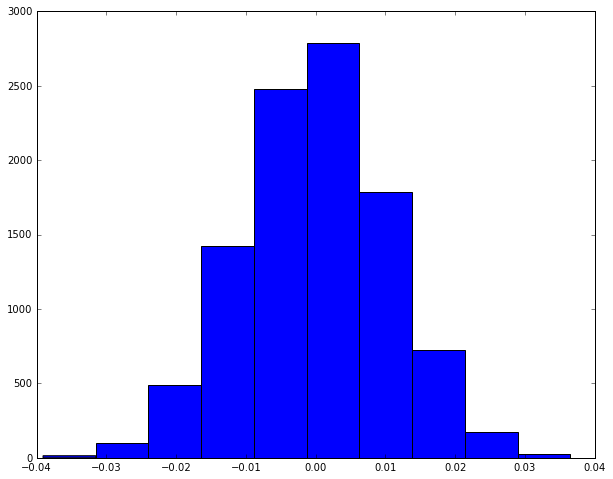

In [647]:
plt.hist(stat)
plt.show()

In [644]:
idx_rest = np.setdiff1d(idxs, idx_rts)

np.setdiff1d(np.union1d(idx_rts, idx_rest), idxs)


array([], dtype=int64)

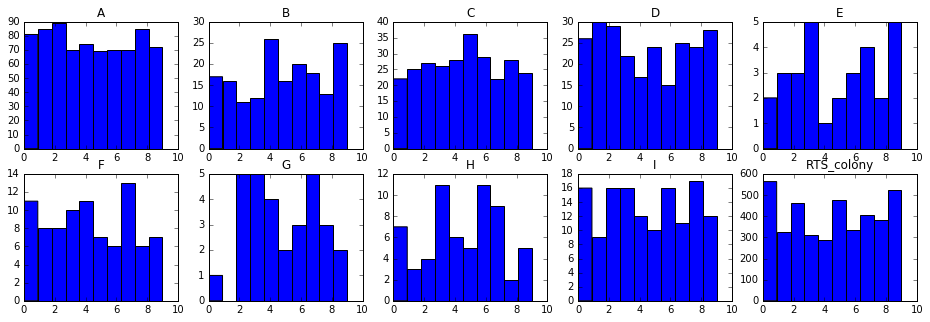

In [558]:
# # Decomposition of Last DIGIT FOR COLONY DATA

# last_digit_colony = {}
# plt.figure(figsize = [16,5])
# for group in range(rest_colony_grouped.shape[0]):
#     last_digit_colony[group] = compute_last_digit(rest_colony_grouped[group])
#     plt.subplot(2,5, group+1)
#     plot_np_hist(last_digit_colony[group], names_colony[group])
# plt.subplot(2,5,10)
# plot_np_hist(compute_last_digit(rts_colony), 'RTS_colony', True)
# plt.show()